In [1]:
rm(list=ls())

source("./ins_paquetes.R")
ins_paquetes('MLmetrics','reshape','data.table','dplyr',
             'party','lattice','sqldf','ggplot2','mlr',
             'corrplot','haven','pROC','reshape2','e1071')

Warning message:
"package 'MLmetrics' was built under R version 3.6.3"
Attaching package: 'MLmetrics'

The following object is masked from 'package:base':

    Recall

Warning message:
"package 'reshape' was built under R version 3.6.3"Warning message:
"package 'data.table' was built under R version 3.6.3"
Attaching package: 'data.table'

The following object is masked from 'package:reshape':

    melt


Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following object is masked from 'package:reshape':

    rename

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'party' was built under R version 3.6.3"Warning message:
"package 'mvtnorm' was built under R version 3.6.3"Warning message:
"package 'modeltools' was built under R version 3.6.3"Warning message:
"package 'struccha


Bellow Packages Successfully Installed:

 MLmetrics    reshape data.table      dplyr      party    lattice      sqldf 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
   ggplot2        mlr   corrplot      haven       pROC   reshape2      e1071 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 


In [2]:
getwd()
setwd('C:/Users/Aron/Desktop/Analitica/S5')

[1] "C:/Users/Aron/Desktop/Analitica/S5"

In [3]:
library(dplyr)
library(MLmetrics)
library(corrplot)
library(mlr)
library(sqldf)
library(ggplot2)
library(haven)
library(pROC)
library(reshape2)

In [4]:
datos <- haven::read_sav("./datasets/Churn.sav")
datos <- data.frame(datos)
head(datos)

ID,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,CHURN
0,57,1,1,2,27535.3,1,1
4,68,1,1,2,81000.9,2,1
8,34,2,2,0,87467.1,1,0
10,60,2,1,2,83220.6,2,1
13,28,1,1,2,20850.4,2,1
17,52,2,2,0,84112.6,2,0


In [5]:
########### 3) TRATAMIENTO DE LA DATA ################# 

## en primer lugar ver el analisis descriptivo de la data

datos$SEXO <- as.factor(datos$SEXO)
datos$CIVIL <- as.factor(datos$CIVIL)
datos$AUTO <- as.factor(datos$AUTO)
datos$CHURN <- as.factor(datos$CHURN)

resumen <- data.frame(mlr::summarizeColumns(datos))
write.csv(resumen,"output/tabla_resumen_logistica.csv")
resumen

name,type,na,mean,disp,median,mad,min,max,nlevs
ID,numeric,0,2.538752e+03,1.459052e+03,2595.0,1851.7674,0.000,4999.0,0
EDAD,numeric,0,5.745279e+01,2.270700e+01,58.0,28.1694,18.000,97.0,0
SEXO,factor,0,NA,4.996283e-01,NA,NA,672.000,673.0,2
CIVIL,factor,0,NA,4.052045e-01,NA,NA,545.000,800.0,2
HIJOS,numeric,0,9.918216e-01,8.232621e-01,1.0,1.4826,0.000,2.0,0
INGRESO,numeric,0,5.064071e+04,2.835441e+04,50290.7,36315.1009,110.284,99832.9,0
AUTO,factor,0,NA,3.152416e-01,NA,NA,424.000,921.0,2
CHURN,factor,0,NA,3.814126e-01,NA,NA,513.000,832.0,2


In [6]:
########### 4)  ANALISIS  ###################### 

## ver correlacion antes de categorizar

source("./funciones.R")

## Generamos una copia para realizar la correlacion
data_datos <- datos
data_datos[,1:ncol(data_datos)] <- lapply(data_datos[,1:ncol(data_datos)],as.character)
data_datos[,1:ncol(data_datos)] <- lapply(data_datos[,1:ncol(data_datos)],as.numeric)

corre <- cor(data_datos,method = c("spearman"))

## colocamos la primera funcion de correlacion
corre <- correlacionS(corre)
corre$filtro <- ifelse(abs(corre$cor)>0.6,1,0)

write.csv(corre,"output/correlacion_variables_logistica.csv",row.names = F)

corre

i,j,cor,filtro
ID,EDAD,0.008191850,0
ID,SEXO,0.035578858,0
EDAD,SEXO,0.043504726,0
ID,CIVIL,-0.021944462,0
EDAD,CIVIL,0.036687928,0
SEXO,CIVIL,0.026359429,0
ID,HIJOS,-0.004650069,0
EDAD,HIJOS,-0.032336189,0
SEXO,HIJOS,-0.019122573,0
CIVIL,HIJOS,-0.035926992,0


In [7]:
## primer modelo logistica ##

# retiramos la variable correlacionada

data.frame(names(datos))

formula <-    CHURN ~
         EDAD+
         SEXO+
        CIVIL+
        HIJOS+
      INGRESO+
         AUTO
        
              
modelo1 <- glm(formula,data=datos,family = binomial() )

names.datos.
ID
EDAD
SEXO
CIVIL
HIJOS
INGRESO
AUTO
CHURN


In [8]:
# indicadores mediante la segunda funcion
calcula_indicadores(modelo1)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


variable,Gini,KS
logistico,58.94,56.04


In [9]:
# ver la significancia del modelo
summary(modelo1)


Call:
glm(formula = formula, family = binomial(), data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8069  -0.6306  -0.4777   0.9101   2.3761  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.342e-01  2.553e-01   2.092 0.036410 *  
EDAD         1.048e-02  2.943e-03   3.561 0.000370 ***
SEXO2       -2.485e+00  1.428e-01 -17.406  < 2e-16 ***
CIVIL2       3.088e-02  1.349e-01   0.229 0.818955    
HIJOS       -1.058e-01  8.079e-02  -1.310 0.190139    
INGRESO     -8.119e-06  2.356e-06  -3.446 0.000568 ***
AUTO2       -1.072e-01  1.423e-01  -0.753 0.451262    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1788.2  on 1344  degrees of freedom
Residual deviance: 1391.3  on 1338  degrees of freedom
AIC: 1405.3

Number of Fisher Scoring iterations: 4


In [10]:
## reajustando
formula <-    CHURN ~
  EDAD+
  SEXO+
  #CIVIL+
  #HIJOS+
  INGRESO
  #AUTO

modelo2 <- glm(formula,data=datos,family = binomial())

In [11]:
# indicadores mediante la segunda funcion
calcula_indicadores(modelo2)

Warning message in ks.test(x = objeto_logit$fitted.values[which(objeto_logit$y == :
"p-value will be approximate in the presence of ties"Setting levels: control = 0, case = 1
Setting direction: controls < cases


variable,Gini,KS
logistico,58.62,56.43


Menos valor AIC --> Mejor modelo

In [12]:
# ver la significancia del modelo
summary(modelo2)


Call:
glm(formula = formula, family = binomial(), data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7474  -0.6227  -0.4799   0.9218   2.3539  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.528e-01  2.131e-01   1.655 0.097863 .  
EDAD         1.057e-02  2.935e-03   3.601 0.000316 ***
SEXO2       -2.475e+00  1.423e-01 -17.391  < 2e-16 ***
INGRESO     -7.994e-06  2.352e-06  -3.398 0.000678 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1788.2  on 1344  degrees of freedom
Residual deviance: 1393.7  on 1341  degrees of freedom
AIC: 1401.7

Number of Fisher Scoring iterations: 4


Para quitar el intercepto

In [13]:
## reajustando

formula <-    CHURN ~
  EDAD+
  SEXO+
  #CIVIL+
  #HIJOS+
  INGRESO-1
#AUTO

modelo3 <- glm(formula,data=datos,family = binomial())

In [14]:
# indicadores mediante la segunda funcion
calcula_indicadores(modelo3)

Warning message in ks.test(x = objeto_logit$fitted.values[which(objeto_logit$y == :
"p-value will be approximate in the presence of ties"Setting levels: control = 0, case = 1
Setting direction: controls < cases


variable,Gini,KS
logistico,58.62,56.43


In [15]:
# ver la significancia del modelo
summary(modelo3)


Call:
glm(formula = formula, family = binomial(), data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7474  -0.6227  -0.4799   0.9218   2.3539  

Coefficients:
          Estimate Std. Error z value Pr(>|z|)    
EDAD     1.057e-02  2.935e-03   3.601 0.000316 ***
SEXO1    3.528e-01  2.131e-01   1.655 0.097863 .  
SEXO2   -2.123e+00  2.348e-01  -9.040  < 2e-16 ***
INGRESO -7.994e-06  2.352e-06  -3.398 0.000678 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1864.6  on 1345  degrees of freedom
Residual deviance: 1393.7  on 1341  degrees of freedom
AIC: 1401.7

Number of Fisher Scoring iterations: 4


In [16]:
## representacion de las variables

datosF <- sqldf::sqldf("select   EDAD,  SEXO,  INGRESO from datos")
datosF$probabilidades_result1 <- predict(modelo3, newdata = datos, type = "response")

head(datosF)

EDAD,SEXO,INGRESO,probabilidades_result1
57,1,27535.3,0.67595696
68,1,81000.9,0.60447301
34,2,87467.1,0.07853421
60,2,83220.6,0.10399313
28,1,20850.4,0.61824730
52,2,84112.6,0.09575334


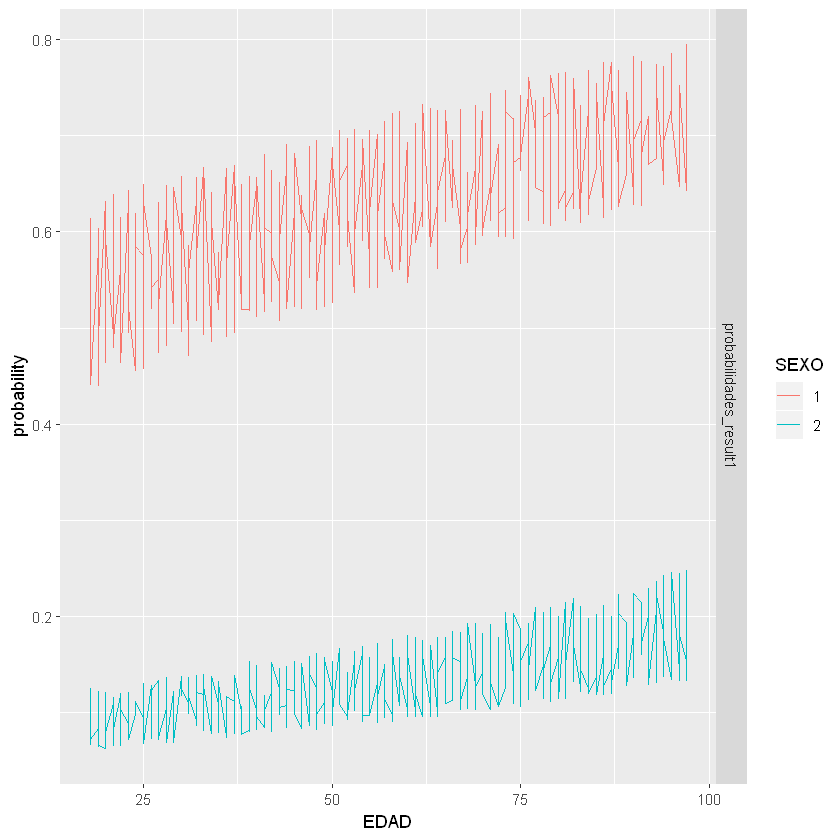

In [17]:
tabla <- reshape2::melt(datosF, id.vars = c("EDAD", "SEXO","INGRESO"), value.name = "probability")

# Grafico de las probabilidades

ggplot2::ggplot(tabla, aes(x = EDAD, 
                           y = probability, colour = SEXO)) + geom_line() + 
  facet_grid(variable ~., scales = "free")



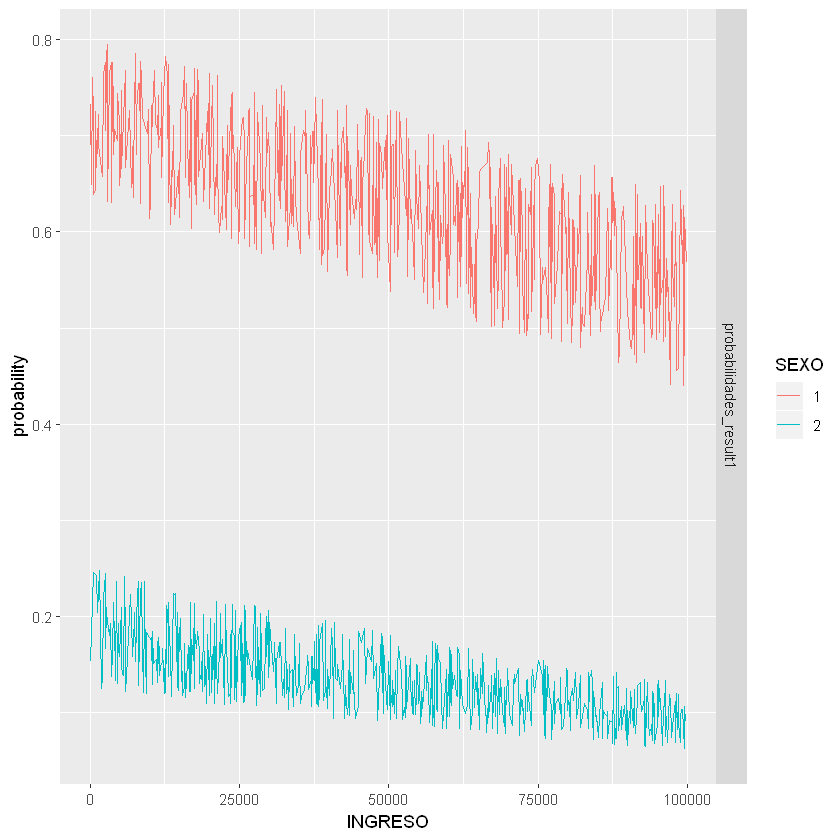

In [18]:
ggplot2::ggplot(tabla, aes(x = INGRESO, 
                           y = probability, colour = SEXO)) + geom_line() + 
  facet_grid(variable ~., scales = "free")

In [19]:
## Indicadores

## calcular el AUC
AUC1 <- MLmetrics::AUC(datosF$probabilidades_result1,datos$CHURN)
AUC1

[1] 0.7931005

Cuanto mas valor del GINI, mejor

In [20]:
## calcular el GINI
gini1 <- 2*(AUC1) -1
gini1

[1] 0.5862011

In [21]:
## calcular el LOGLOSS
LogLoss1 <- MLmetrics::LogLoss(datosF$probabilidades_result1,as.numeric(as.character(datos$CHURN)))
LogLoss1

[1] 0.518104

In [22]:
## Calcular el KS
KS1 <- MLmetrics::KS_Stat(datosF$probabilidades_result1,datos$CHURN)
KS1

[1] 56.42595

In [23]:
# Calcular los valores predichos

table(datos$CHURN)


  0   1 
832 513 

In [24]:
PRED <- ifelse(datosF$probabilidades_result1<=0.5,0,1) # pto de corte 0.5
#PRED <- ifelse(datosF$probabilidades_result1<=mean(datosF$probabilidades_result1),0,1)
PRED <- as.factor(PRED)
head(PRED)

[1] 1 1 0 0 1 0
Levels: 0 1

In [25]:
# Calcular la matriz de confusion
tabla <- caret::confusionMatrix(PRED,datos$CHURN,positive = "1")
tabla

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 611  95
         1 221 418
                                          
               Accuracy : 0.7651          
                 95% CI : (0.7415, 0.7875)
    No Information Rate : 0.6186          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5245          
                                          
 Mcnemar's Test P-Value : 2.039e-12       
                                          
            Sensitivity : 0.8148          
            Specificity : 0.7344          
         Pos Pred Value : 0.6541          
         Neg Pred Value : 0.8654          
             Prevalence : 0.3814          
         Detection Rate : 0.3108          
   Detection Prevalence : 0.4751          
      Balanced Accuracy : 0.7746          
                                          
       'Positive' Class : 1               
                              

In [26]:
# sensibilidad
Sensitivity1 <- MLmetrics::Sensitivity(PRED,datos$CHURN)
Sensitivity1

[1] 0.8654391

In [27]:
#Specificity
Specificity1 <- MLmetrics::Specificity(PRED,datos$CHURN)
Specificity1

[1] 0.6541471

In [28]:
# Precision
Accuracy1 <- MLmetrics::Accuracy(PRED,datos$CHURN)
Accuracy1

[1] 0.7650558

In [29]:
# Calcular el error de mala clasificaci?n
error1 <- 1-Accuracy1
error1

[1] 0.2349442

In [30]:
# indicadores
AUC1
gini1
LogLoss1
KS1
Accuracy1
error1
Sensitivity1
Specificity1

[1] 0.7931005

[1] 0.5862011

[1] 0.518104

[1] 56.42595

[1] 0.7650558

[1] 0.2349442

[1] 0.8654391

[1] 0.6541471

In [31]:
########### 5) SEGUNDO ANALISIS  #################

formula <-    CHURN ~
  EDAD+
  SEXO+
  CIVIL+
  HIJOS+
  INGRESO+
  AUTO

modelo4 <- glm(formula,data=datos,family=binomial(link=cloglog) )
modelo4


Call:  glm(formula = formula, family = binomial(link = cloglog), data = datos)

Coefficients:
(Intercept)         EDAD        SEXO2       CIVIL2        HIJOS      INGRESO  
 -1.232e-01    9.173e-03   -2.005e+00    2.567e-03   -6.694e-02   -5.037e-06  
      AUTO2  
 -9.941e-02  

Degrees of Freedom: 1344 Total (i.e. Null);  1338 Residual
Null Deviance:	    1788 
Residual Deviance: 1384 	AIC: 1398

In [32]:
# indicadores mediante la segunda funcion
calcula_indicadores(modelo4)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


variable,Gini,KS
logistico,58.94,56.75


In [33]:
# ver la significancia del modelo

summary(modelo4)


Call:
glm(formula = formula, family = binomial(link = cloglog), data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9602  -0.6107  -0.4850   0.8947   2.3016  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.232e-01  1.762e-01  -0.699  0.48429    
EDAD         9.173e-03  2.060e-03   4.453 8.46e-06 ***
SEXO2       -2.005e+00  1.181e-01 -16.976  < 2e-16 ***
CIVIL2       2.567e-03  9.406e-02   0.027  0.97823    
HIJOS       -6.694e-02  5.642e-02  -1.186  0.23547    
INGRESO     -5.037e-06  1.630e-06  -3.089  0.00201 ** 
AUTO2       -9.941e-02  9.844e-02  -1.010  0.31255    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1788.2  on 1344  degrees of freedom
Residual deviance: 1384.2  on 1338  degrees of freedom
AIC: 1398.2

Number of Fisher Scoring iterations: 5


In [34]:
## reajustando

formula <-    CHURN ~
  EDAD+
  SEXO+
  #CIVIL+
  #HIJOS+
  INGRESO#+
  #AUTO


modelo5 <- glm(formula,data=datos,family=binomial(link=cloglog) )

In [35]:
# indicadores mediante la segunda funcion
calcula_indicadores(modelo5)

Warning message in ks.test(x = objeto_logit$fitted.values[which(objeto_logit$y == :
"p-value will be approximate in the presence of ties"Setting levels: control = 0, case = 1
Setting direction: controls < cases


variable,Gini,KS
logistico,58.5,57.42


In [36]:
# ver la significancia del modelo

summary(modelo5)


Call:
glm(formula = formula, family = binomial(link = cloglog), data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8632  -0.6063  -0.4894   0.8997   2.2856  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.648e-01  1.491e-01  -1.776  0.07577 .  
EDAD         9.224e-03  2.052e-03   4.495 6.96e-06 ***
SEXO2       -2.000e+00  1.180e-01 -16.943  < 2e-16 ***
INGRESO     -4.968e-06  1.627e-06  -3.053  0.00226 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1788.2  on 1344  degrees of freedom
Residual deviance: 1386.7  on 1341  degrees of freedom
AIC: 1394.7

Number of Fisher Scoring iterations: 5


In [37]:
## reajustando

formula <-    CHURN ~
  EDAD+
  SEXO+
  #CIVIL+
  #HIJOS+
  INGRESO -1 #+
#AUTO

In [38]:
modelo6 <- glm(formula,data=datos,family=binomial(link=cloglog) )

In [39]:
# indicadores mediante la segunda funcion
calcula_indicadores(modelo6)

Warning message in ks.test(x = objeto_logit$fitted.values[which(objeto_logit$y == :
"p-value will be approximate in the presence of ties"Setting levels: control = 0, case = 1
Setting direction: controls < cases


variable,Gini,KS
logistico,58.5,57.42


In [40]:
# ver la significancia del modelo

summary(modelo6)


Call:
glm(formula = formula, family = binomial(link = cloglog), data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8632  -0.6063  -0.4894   0.8997   2.2856  

Coefficients:
          Estimate Std. Error z value Pr(>|z|)    
EDAD     9.224e-03  2.052e-03   4.495 6.96e-06 ***
SEXO1   -2.648e-01  1.491e-01  -1.776  0.07577 .  
SEXO2   -2.265e+00  1.797e-01 -12.602  < 2e-16 ***
INGRESO -4.968e-06  1.627e-06  -3.053  0.00226 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2134.6  on 1345  degrees of freedom
Residual deviance: 1386.7  on 1341  degrees of freedom
AIC: 1394.7

Number of Fisher Scoring iterations: 5


In [41]:
## Indicadores

datosF$probabilidades_result2 <- predict(modelo6, newdata =  datos,type="response")

## calcular el AUC
AUC2 <- MLmetrics::AUC(datosF$probabilidades_result2,datos$CHURN)

## calcular el GINI
gini2 <- 2*(AUC2) -1

## calcular el LOGLOSS
LogLoss2 <- MLmetrics::LogLoss(datosF$probabilidades_result2,as.numeric(as.character(datos$CHURN)))

## Calcular el KS
KS2 <- MLmetrics::KS_Stat(datosF$probabilidades_result2,datos$CHURN)

# Calcular los valores predichos

PRED <- ifelse(datosF$probabilidades_result2<=0.5,0,1) # pto de corte 0.5
PRED <- as.factor(PRED)

# Calcular la matriz de confusion
tabla <- caret::confusionMatrix(PRED,datos$CHURN,positive = "1")
tabla

# sensibilidad
Sensitivity2 <- MLmetrics::Sensitivity(PRED,datos$CHURN)

#Specificity
Specificity2 <- MLmetrics::Specificity(PRED,datos$CHURN)

# Precision
Accuracy2 <- MLmetrics::Accuracy(PRED,datos$CHURN)

# Calcular el error de mala clasificaci?n
error2 <- 1-Accuracy2

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 627  98
         1 205 415
                                          
               Accuracy : 0.7747          
                 95% CI : (0.7514, 0.7968)
    No Information Rate : 0.6186          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5409          
                                          
 Mcnemar's Test P-Value : 1.132e-09       
                                          
            Sensitivity : 0.8090          
            Specificity : 0.7536          
         Pos Pred Value : 0.6694          
         Neg Pred Value : 0.8648          
             Prevalence : 0.3814          
         Detection Rate : 0.3086          
   Detection Prevalence : 0.4610          
      Balanced Accuracy : 0.7813          
                                          
       'Positive' Class : 1               
                              

In [42]:
# indicadores
AUC2
gini2
LogLoss2
KS2
Accuracy2
error2
Sensitivity2
Specificity2

[1] 0.7924867

[1] 0.5849734

[1] 0.5155055

[1] 57.41678

[1] 0.7747212

[1] 0.2252788

[1] 0.8648276

[1] 0.6693548

In [43]:
## Tabla comparativa

AUC <- rbind(AUC1,AUC2); AUC <- round(AUC,3)
Gini <- rbind(gini1,gini2); Gini <- round(Gini,3)
LogLoss <- rbind(LogLoss1,LogLoss2); LogLoss <- round(LogLoss,4)
KS <- rbind(KS1,KS2); KS <- round(KS,4)
Accuracy <- rbind(Accuracy1,Accuracy2); Accuracy <- round(Accuracy,3)
Sensitivity <- rbind(Sensitivity1,Sensitivity2); Sensitivity <- round(Sensitivity,3)
Specificity <- rbind(Specificity1,Specificity2); Specificity <- round(Specificity,3)

Indicadores <- cbind(AUC,Gini,LogLoss,KS,Accuracy,Sensitivity,Specificity)
rownames(Indicadores)<- c('modelo_logit','modelo_cloglog')
colnames(Indicadores)<- c('AUC','Gini','LogLoss','KS','Accuracy','Sensitivity','Specificity')

Indicadores

,AUC,Gini,LogLoss,KS,Accuracy,Sensitivity,Specificity
modelo_logit,0.793,0.586,0.5181,56.4260,0.765,0.865,0.654
modelo_cloglog,0.792,0.585,0.5155,57.4168,0.775,0.865,0.669
